###  Libraries

In [84]:
from __future__ import annotations

import pathlib
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import joblib

# Visuals / utils
from visualizations import (
    na_visualization,
    correlation_heatmap,
    plot_feature_importance,
    feature_importance_heatmap,
    plot_pca_variance,
)
from utils import detect_outliers_iqr, build_features, compute_feature_importance


##  Introspective view of the dataset 

In [85]:
df=pd.read_csv('data\student-data.csv')
#
display(df.head(10))

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,passed
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,no,4,3,4,1,1,3,6,no
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,no,5,3,3,1,1,3,4,no
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,no,4,3,2,2,3,3,10,yes
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,3,2,2,1,1,5,2,yes
4,GP,F,16,U,GT3,T,3,3,other,other,...,no,no,4,3,2,1,2,5,4,yes
5,GP,M,16,U,LE3,T,4,3,services,other,...,yes,no,5,4,2,1,2,5,10,yes
6,GP,M,16,U,LE3,T,2,2,other,other,...,yes,no,4,4,4,1,1,3,0,yes
7,GP,F,17,U,GT3,A,4,4,other,teacher,...,no,no,4,1,4,1,1,1,6,no
8,GP,M,15,U,LE3,A,3,2,services,other,...,yes,no,4,2,2,1,1,1,0,yes
9,GP,M,15,U,GT3,T,3,4,other,other,...,yes,no,5,5,1,1,1,5,0,yes



*** BASIC INFORMATION ***

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 31 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-nu

None


Shape        : (395, 31)

Numeric cols : ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
Categorical  : ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'passed']


,count,mean,std,min,25%,50%,75%,max
age,395.000000,16.696203,1.276043,15.000000,16.000000,17.000000,18.000000,22.000000
Medu,395.000000,2.749367,1.094735,0.000000,2.000000,3.000000,4.000000,4.000000
Fedu,395.000000,2.521519,1.088201,0.000000,2.000000,2.000000,3.000000,4.000000
traveltime,395.000000,1.448101,0.697505,1.000000,1.000000,1.000000,2.000000,4.000000
studytime,395.000000,2.035443,0.839240,1.000000,1.000000,2.000000,2.000000,4.000000
failures,395.000000,0.334177,0.743651,0.000000,0.000000,0.000000,0.000000,3.000000
famrel,395.000000,3.944304,0.896659,1.000000,4.000000,4.000000,5.000000,5.000000
freetime,395.000000,3.235443,0.998862,1.000000,3.000000,3.000000,4.000000,5.000000
goout,395.000000,3.108861,1.113278,1.000000,2.000000,3.000000,4.000000,5.000000
Dalc,395.000000,1.481013,0.890741,1.000000,1.000000,1.000000,2.000000,5.000000


Detected 156 potential outliers across numeric features.
156 índices con posibles outliers


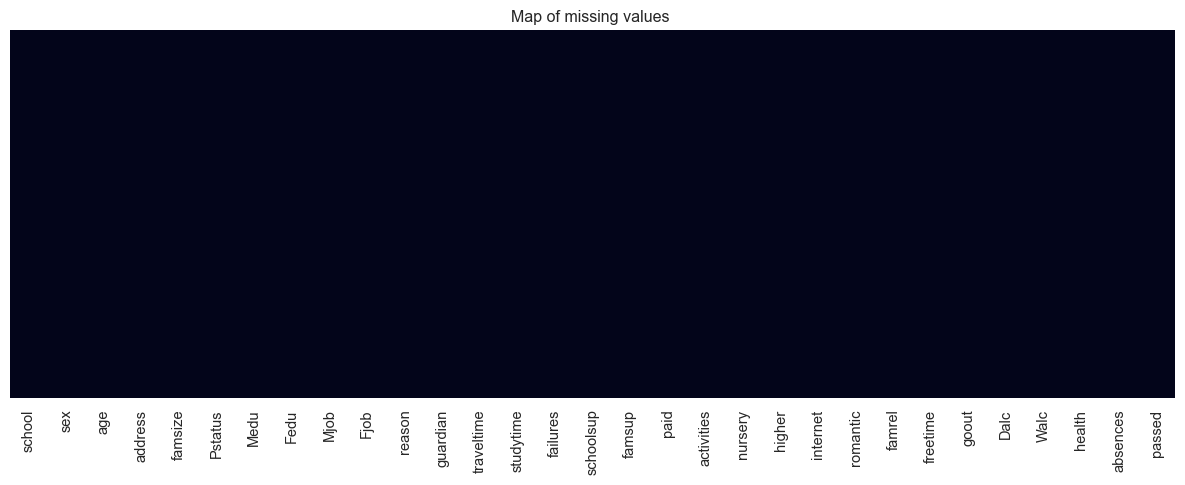

There are no missing values


In [86]:
from visualizations import na_visualization 


print("\n*** BASIC INFORMATION ***\n")
display(df.info())
print("\nShape        :", df.shape)
print("\nNumeric cols :", df.select_dtypes("number").columns.tolist())
print("Categorical  :", df.select_dtypes("object").columns.tolist())
display(df.describe().transpose().style.background_gradient(cmap='Blues'))
# 1.2 Detección de outliers
outliers = detect_outliers_iqr(df.select_dtypes("number"))           
print(f"{len(outliers)} índices con posibles outliers")
na_visualization(df)


Hablar sobre la base de datos, comentar un poco no hace falta extederse demasiado



c:\Users\alfre\Desktop\clase\Elements of Artificial Inteligence\Project-2\student-intervention-ml-pipeline\visualizations.py:164: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


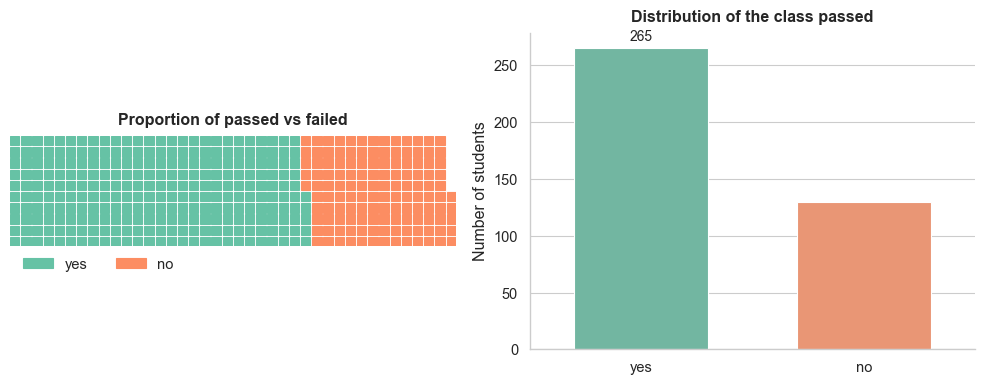

In [87]:
from visualizations import class_distribution
from pywaffle import Waffle
import matplotlib.pyplot as plt  
import seaborn as sns  

class_distribution(df)

### **Choice of Class Encoding (pass = 0, fail = 1)**
Our label encoding was driven by the operational goal of the project rather than by convenience of the code. The assignment brief explicitly states that “the main goal … is to develop a machine-learning pipeline capable of predicting whether a given student will pass their final exam, thus allowing an intervention system that may flag individual students requiring extra attention and support EIACD_Assignment_2_2024…. In practice, those “individual students” are precisely the ones at risk of failing, so we marked failure as the positive class (1) and success as the negative class (0). This decision has three main advantages:

* **Metric focus on the target population.**
Precision, recall, F-score, and the area under the Precision-Recall curve are all computed with respect to the class coded as 1. By assigning fail = 1, these metrics now directly quantify the model’s ability to identify students who need help most urgently.

* **Interpretable probabilities for early-warning systems.**
The classifier’s predict_proba() now outputs P(fail) rather than P(pass). Dashboard thresholds can therefore be set on an intuitive “probability of failure” scale (e.g., intervene when risk ≥ 0.30).

* **Alignment with class imbalance techniques.**
As the exploratory visualisations show, the dataset is moderately imbalanced: ≈ 260 passes (67 %) vs 130 failures (33 %).
Figure 1 (waffle plot) highlights this skew, and Figure 2 (bar chart) annotates the exact counts.
Treating the minority (failures) as the positive class is standard practice when applying resampling strategies such as SMOTE or ADASYN that the rubric encourages; it maximises the effectiveness of these techniques on the group that matters.

**Why not the opposite mapping?**
Reversing the labels would leave overall accuracy and AUC unchanged, but it would push the minority class into the background of the evaluation, complicating threshold selection and diluting the pedagogical value of the metrics. Given that the primary objective is intervention, not mere forecasting, the chosen encoding provides clearer, action-oriented insights without affecting the mathematical correctness of the models.

In short, coding pass = 0 and fail = 1 turns every subsequent metric and probability into a direct measure of academic risk, fully supporting the intervention philosophy articulated in the project documentation.



# **EDA**

## Numerical Features

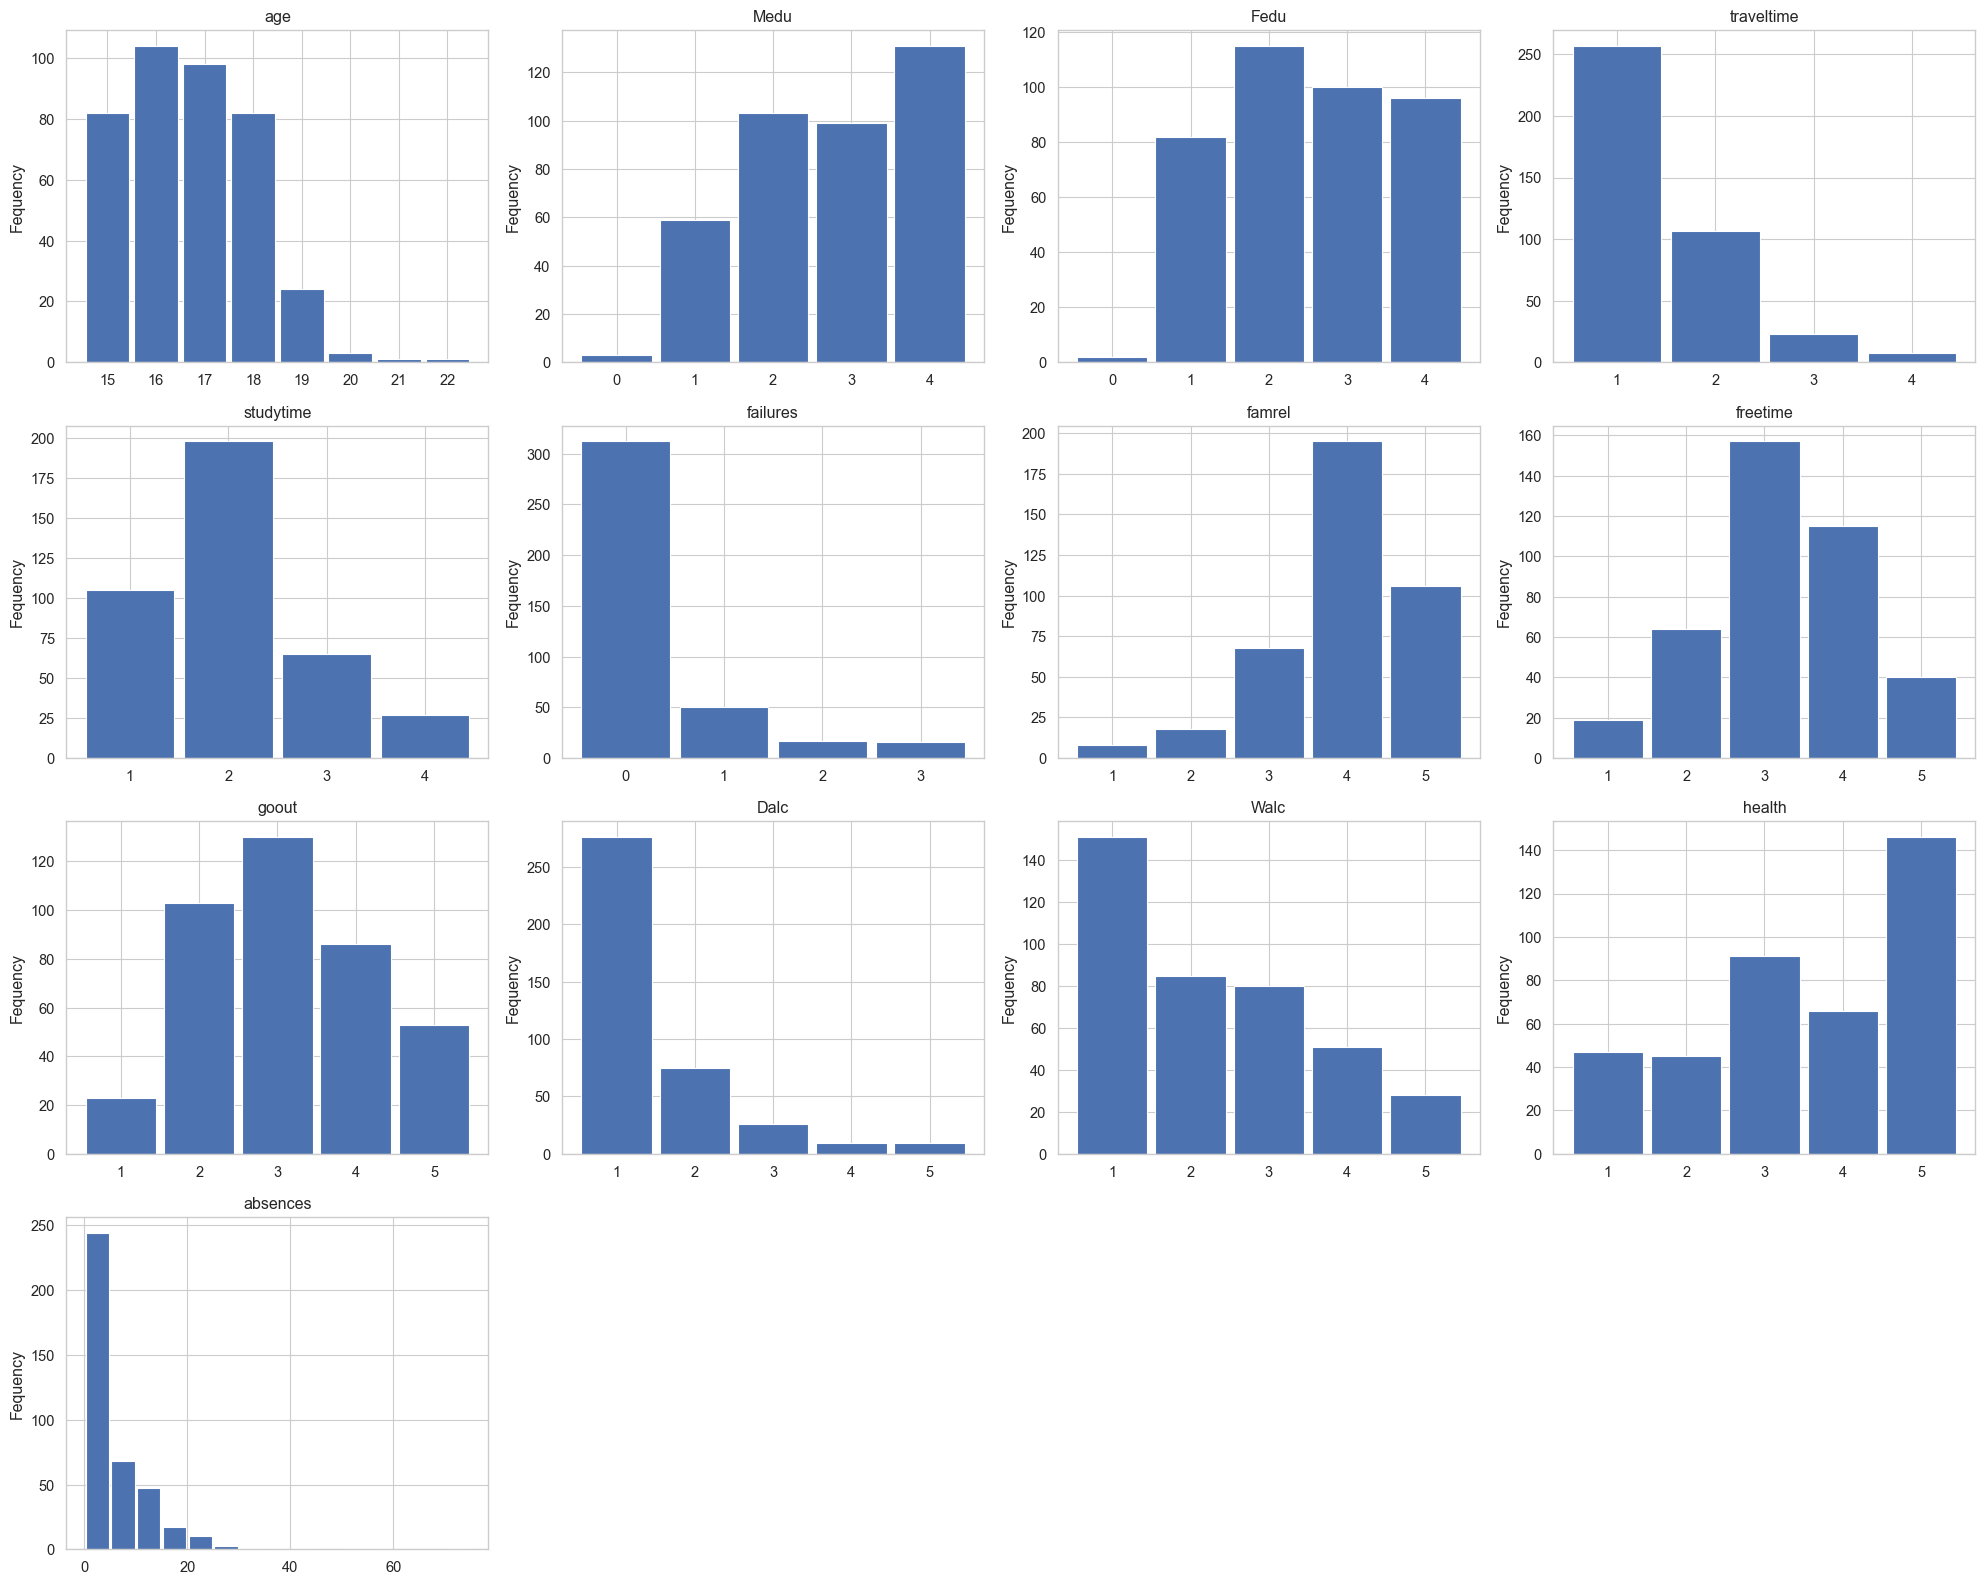

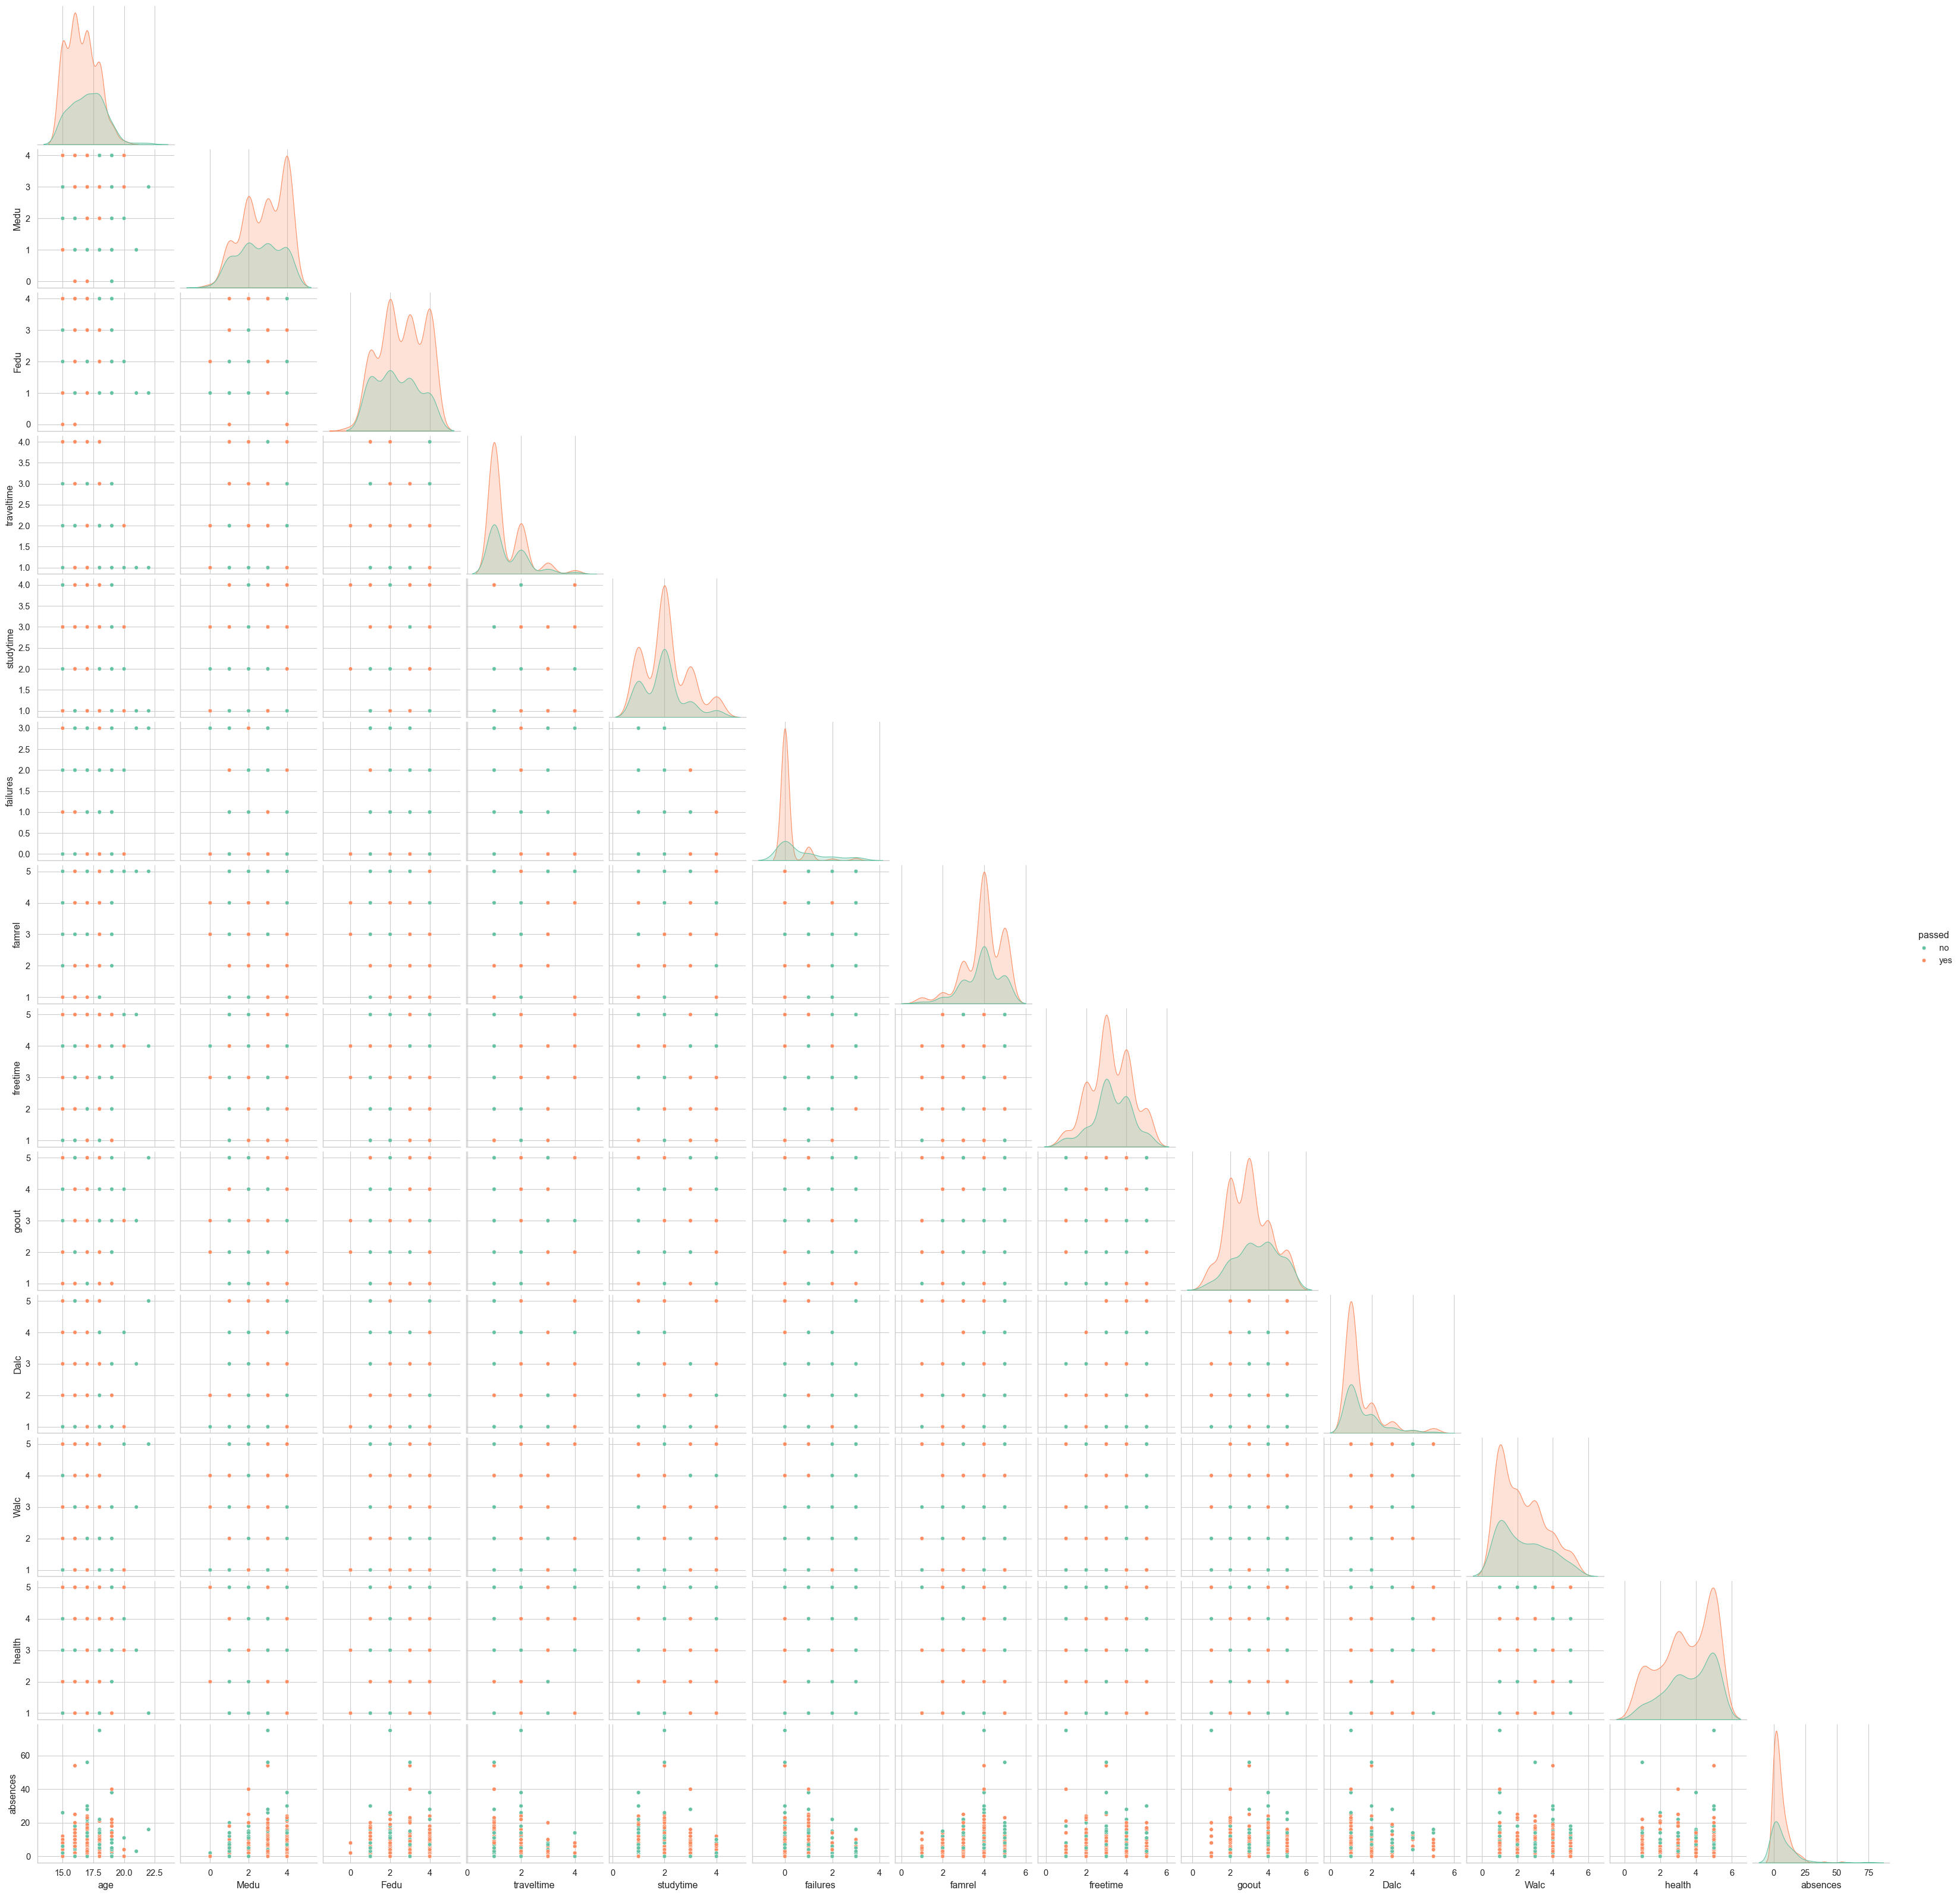

In [88]:
from visualizations import numerical_features_visualization
numerical_features_visualization(df)


**Cosas a mencionar del gráfico de arriba (se tiene que retocar )**


**Figure 1.** Univariate Histograms of Key Numerical Predictors

**Figure 2.** Pairwise distributions and kernel density estimates (diagonal) alongside bivariate scatterplots (off‐diagonal) for key continuous predictors stratified by final exam outcome (“passed” vs. “not passed”).



### Diagonal Panels (Univariate Densities)

Each variable’s marginal distribution is overlaid for students who passed (green) and those who did not (salmon). Notable observations include:

* **Age:** Both groups concentrate between 16–18 years, though the density for non‐passers exhibits a modest rightward skew, suggesting slightly older students are at increased risk of failure.
* **Parental Education (Medu, Fedu):** Pass‐rate density peaks at parental education levels 3–4; by contrast, non‐passers accumulate at levels 1–2, implying a positive association between parental schooling and student success.
* **Travel Time:** Passers predominantly report travel times ≤ 2, whereas non‐passers show appreciable density at 3–4, indicating that lengthy commutes may adversely affect performance.
* **Study Time:** A clear separation emerges: densities for successful students rise markedly at ≥ 2 hours of weekly study, whereas non‐passers cluster below that threshold.
* **Failures:** The vast majority of students without prior failures pass the final (density spike at 0), while densities for one or more past failures shift toward non‐passers.
* **Alcohol Consumption & Social Life (Dalc, Walc, goout):** Non‐passers concentrate at high daily/weekly alcohol use and frequent social outings (levels 4–5), in contrast to passers who are denser at lower levels.
* **Family Relations & Health:** Though these factors display more overlap, passers show a modest density advantage at higher family‐relation and health ratings.
* **Absences:** A long‐tailed distribution emerges: passers cluster tightly below ten absences, whereas non‐passers populate the upper tail, corroborating absenteeism as a risk factor.



### Off-Diagonal Panels (Bivariate Relations)

Scatterplots reveal joint patterns that reinforce univariate findings and suggest interactions:

* **Study Time vs. Failures:** A negative relationship appears: increased study time coincides with fewer past failures, and the green points dominate the high‐study/low‐failures region.
* **Absences vs. Travel Time:** Students with longer commutes tend to accrue more absences; these points are disproportionately salmon, emphasizing the compound effect of travel burden and absenteeism.
* **Alcohol Use vs. Social Activity:** High daily/weekly alcohol consumption combined with frequent outings forms a distinct cluster of non‐passers, underscoring lifestyle factors.
* **Parental Education vs. Failures:** Lower parental education correlates with greater past failures and a higher density of non-passers, while higher Medu/Fedu aligns with student success.
* **Family Relations vs. Health:** Although the correlation is weak, passers are more prevalent in the quadrant of both high family‐relation scores and good health, suggesting a supportive home environment may bolster outcomes.


### Implications for Intervention

These density and scatter patterns collectively identify **protective factors**—low absenteeism, short commute, sufficient study time, absence of prior failures, low alcohol/social distractions, and higher parental education—as well as **risk factors** that can inform early warning systems. The clear separation of passers and non-passers along these dimensions validates their inclusion in a predictive model and guides targeted support strategies (e.g., commuter assistance, study‐skills workshops, and family engagement interventions).


## Categorical Features  

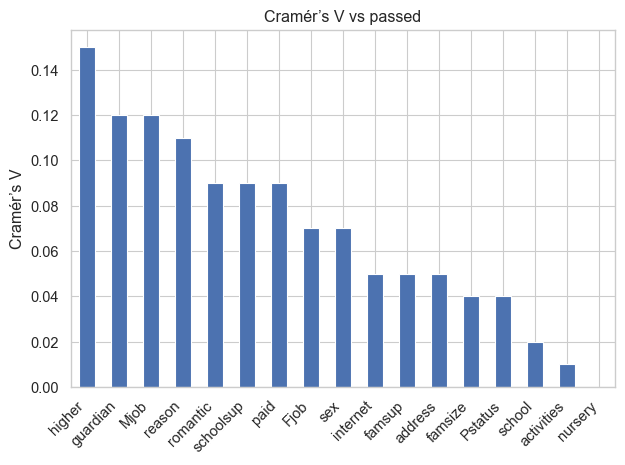

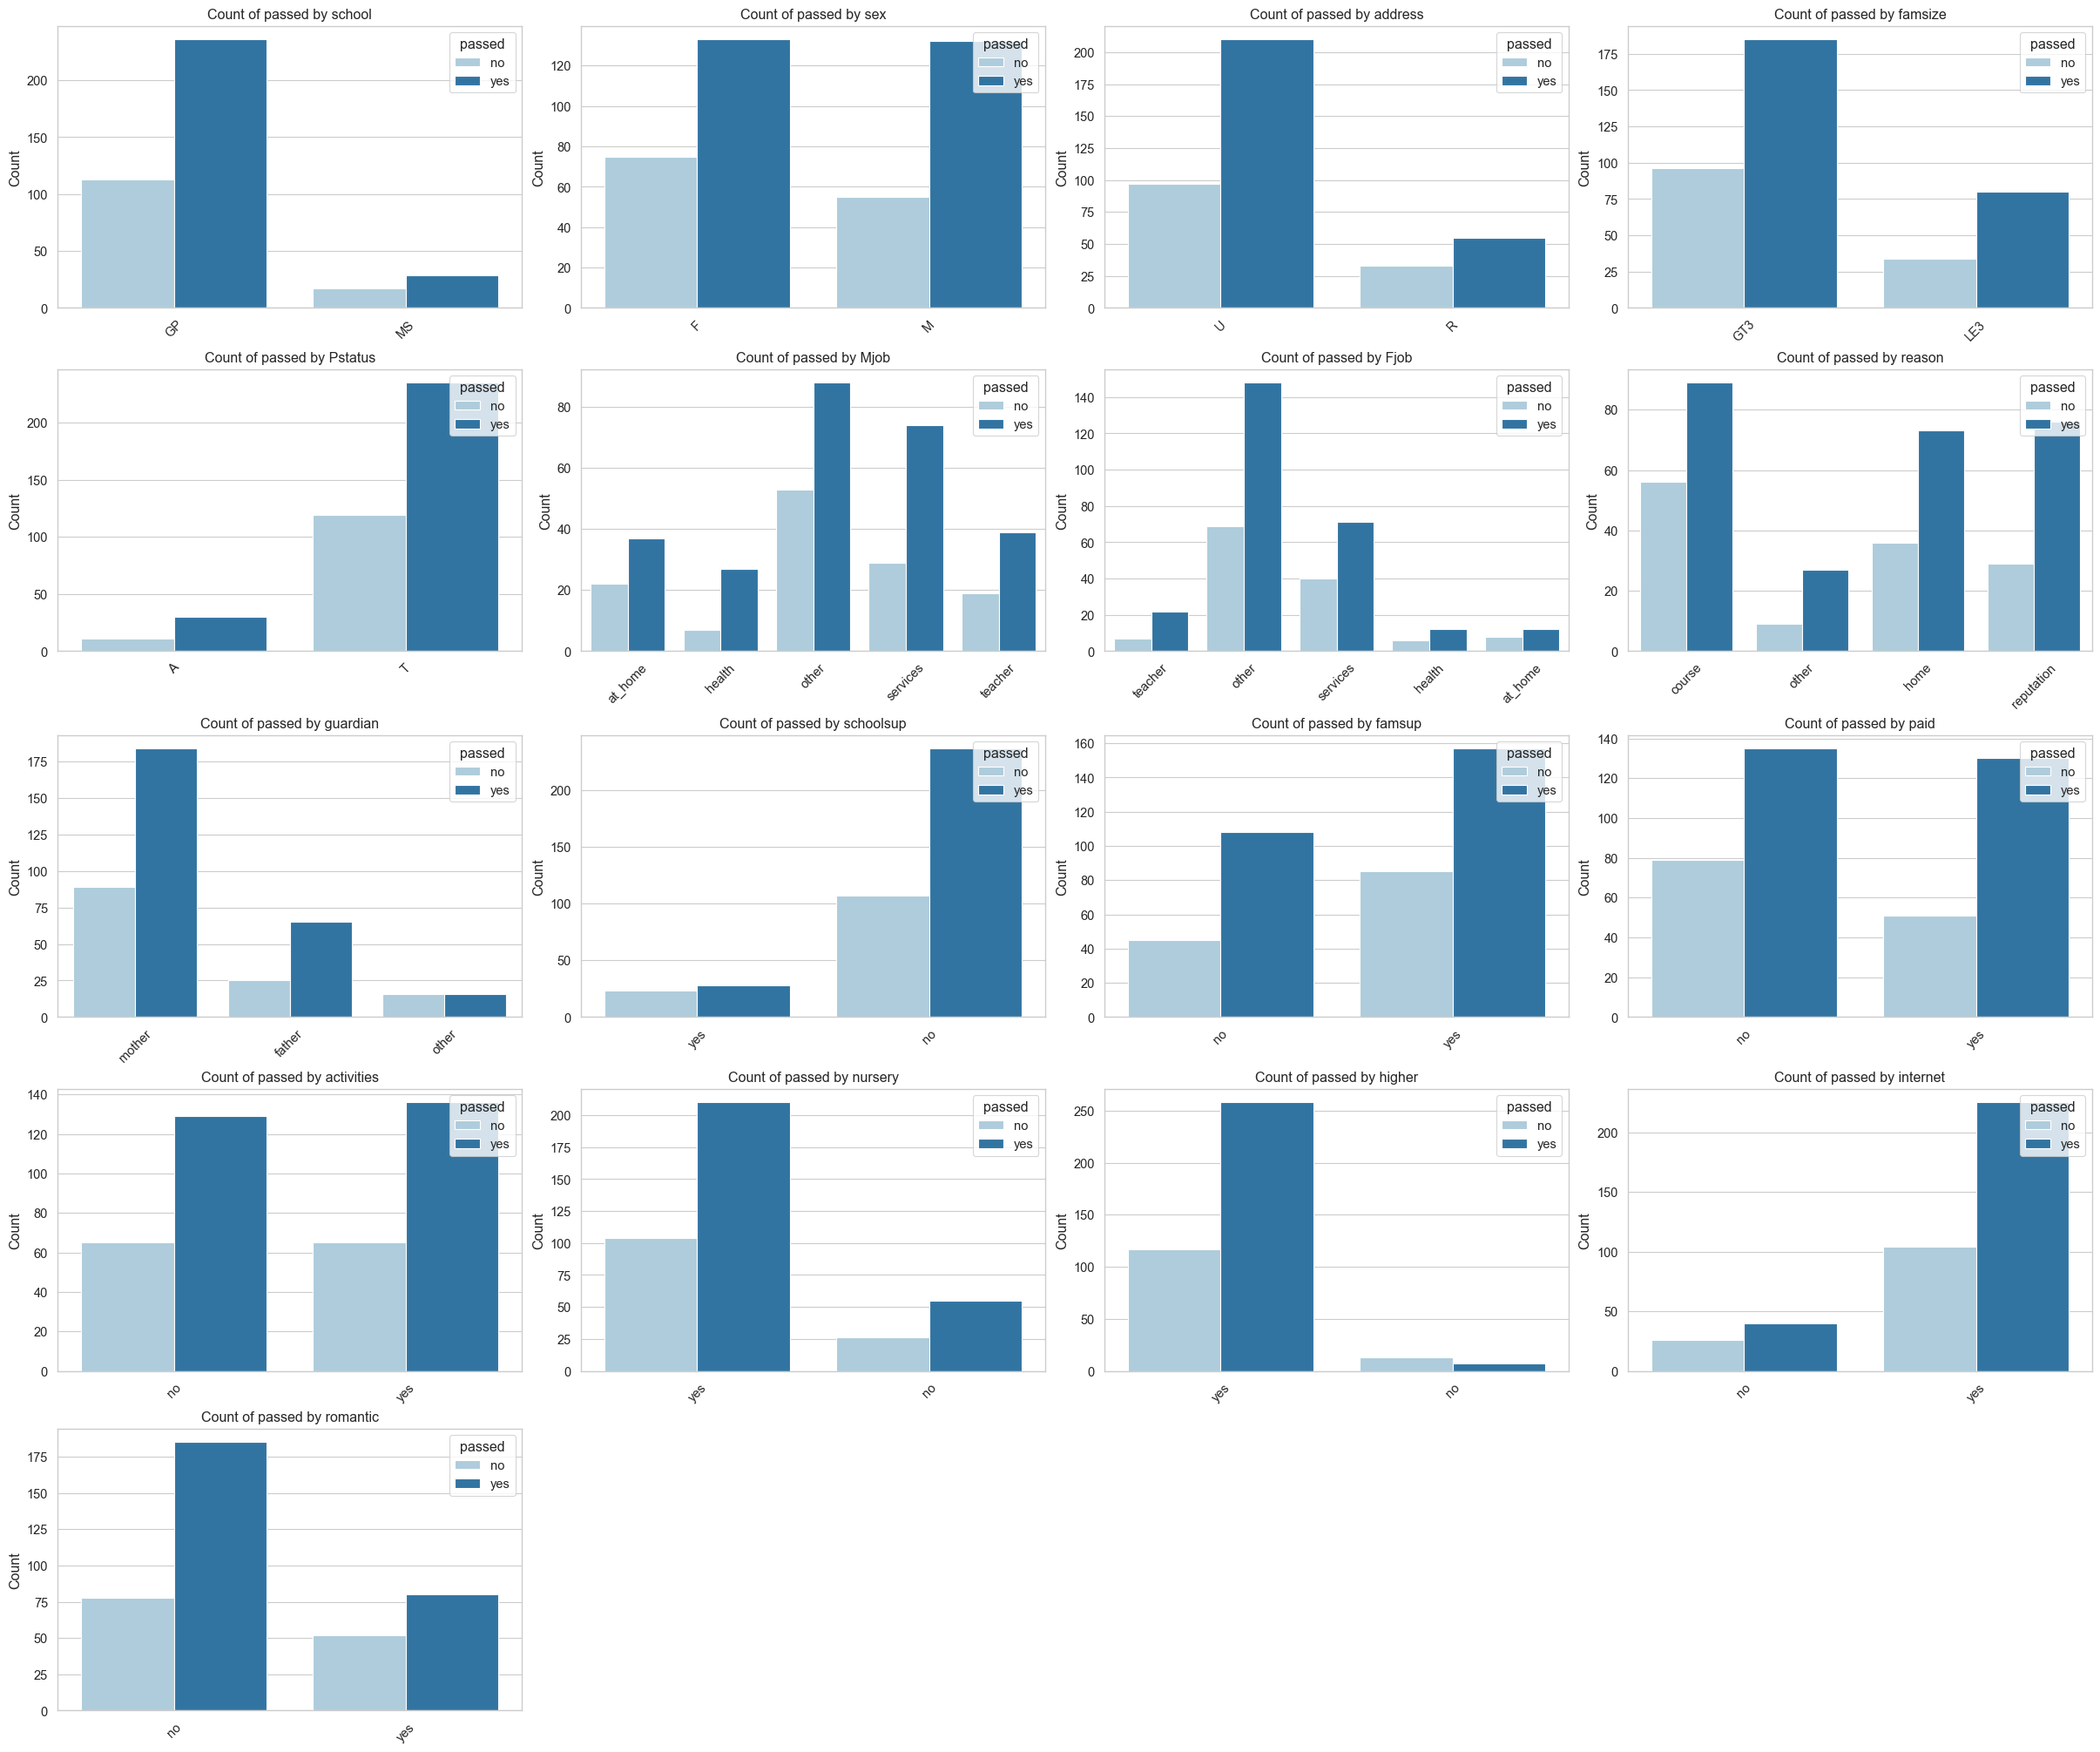

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import math
# 1) Función Cramér’s V
def cramers_v(x, y):
    cm = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(cm)[0]
    n = cm.values.sum()
    return np.sqrt(chi2 / (n * (min(cm.shape) - 1)))

# 2) Definir variables categóricas excluyendo 'passed'
cat_cols = [
    col for col in df.select_dtypes(exclude='number').columns
    if col != 'passed'
]

# 3) Calcular Cramér’s V (sin incluir 'passed' en los predictores)
cramers = {
    col: cramers_v(df[col], df['passed'])
    for col in cat_cols
}
cv_series = pd.Series(cramers).sort_values(ascending=False).round(2)

# 4) Mostrar la serie de Cramér’s V
# 4) Gráfico de barras con etiquetas rotadas 45°
ax = cv_series.plot(kind='bar')
ax.set_title("Cramér’s V vs passed")
ax.set_ylabel("Cramér’s V")
ax.set_xlabel("")
# Rotar etiquetas del eje x
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()


# 5) Gráfico dinámico de countplots apilados para cada variable categórica
n_cols = 4
n_rows = math.ceil(len(cat_cols) / n_cols)
fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(6 * n_cols, 4 * n_rows),
    constrained_layout=True
)

for ax, col in zip(axes.flatten(), cat_cols):
    sns.countplot(
        data=df,
        x=col,
        hue='passed',
        palette='Paired',
        ax=ax
    )
    ax.set_title(f"Count of passed by {col}")
    ax.set_xlabel('')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)
    ax.legend(title='passed', loc='upper right')

# Ocultar subplots vacíos (no habrá uno para 'passed')
for ax in axes.flatten()[len(cat_cols):]:
    ax.set_visible(False)

plt.show()



**Figure X. Cramér’s V for Categorical Predictors vs. Final-Exam Outcome**  
_Cramér’s V_ is a normalized measure of association between two nominal (categorical) variables, derived from the χ² statistic. It ranges from 0 (no association) to 1 (perfect association), making it ideal for comparing the predictive relevance of multiple categorical features against a binary target.

| Predictor                  | Cramér’s V |
|----------------------------|:----------:|
| **higher**                 |   0.15     |
| **guardian**               |   0.12     |
| **Mjob**                   |   0.12     |
| **reason**                 |   0.11     |
| **romantic**               |   0.10     |
| **schoolsup**              |   0.09     |
| **paid**                   |   0.08     |
| **Fjob**                   |   0.08     |
| **sex**                    |   0.07     |
| **internet**               |   0.07     |
| **famsup**                 |   0.05     |
| **address**                |   0.05     |
| **famsize**                |   0.05     |
| **Pstatus**                |   0.04     |
| **school**                 |   0.04     |
| **activities**             |   0.02     |
| **nursery**                |   0.01     |

Key observations:

- **Strongest Associations**  
  - *higher* (V≈0.15): Students who plan to pursue higher education are most strongly differentiated between pass/fail outcomes.  
  - *guardian*, *Mjob* (V≈0.12): The identity of the primary guardian and the mother’s occupation also show relatively high linkage to exam success.

- **Moderate Associations**  
  - *reason*, *romantic*, *schoolsup* (V≈0.09–0.11): School-choice rationale, romantic involvement, and receipt of extra academic support exhibit intermediate predictive value.

- **Weak or Negligible Associations**  
  - *activities*, *nursery* (V<0.03): Participation in extracurricular activities and nursery attendance contribute little to distinguishing pass vs. fail.

These results provide a principled basis for **feature selection**, highlighting socio-demographic variables that are most likely to enhance classification performance in subsequent predictive modeling.```


# **Preprocessing** 

### Train/Test Split 

In [90]:
df['passed']=df['passed'].map({"no":1,"yes":0})
X = df.drop(columns=["passed"])
y = df["passed"]


numeric_cols = X.select_dtypes("number").columns.tolist()
categorical_cols = X.select_dtypes("object").columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("\nSize of Train set      :", X_train.shape)
print("Size of Test set       :", X_test.shape)


Size of Train set      : (316, 30)
Size of Test set       : (79, 30)




Cosas a mencionar  : 

No hay imputacion debido a que no hay ningun NA ni valor faltante 


## Encoding Strategies
1. One-Hot Encoding for Nominals
To avoid imposing spurious ordinal relationships, each category in the three nominal attributes was expanded into independent indicator variables. This yields a sparse, non-hierarchical representation suitable for distance-based or linear classifiers without biasing one level over another.

2. Ordinal Encoding for Ranked Scales
Each ordinal feature (e.g., education levels from 0–4; scales from 1–5) was mapped to its integer rank. This approach preserves monotonic relationships—critical when modelling assumptions exploit increasing or decreasing trends—while avoiding an explosion of dimensions.

3. Binary Mapping for Dichotomous Variables
All yes/no or two-category fields were converted directly into {0, 1}. For example, “yes”→1 and “no”→0, “GP”→0 and “MS”→1, etc. This compact mapping reduces dimensionality and maintains interpretability.

4. Standard Scaling for Continuous Variables
Student age and absence count were standardized to zero mean and unit variance. This normalization mitigates the risk that numerical magnitudes dominate model training and facilitates convergence for gradient-based algorithms.

C:\Users\alfre\AppData\Local\Temp\ipykernel_18660\90577566.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return df.replace({
C:\Users\alfre\AppData\Local\Temp\ipykernel_18660\90577566.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return df.replace({


,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,...,Pstatus,schoolsup,famsup,paid,activities,nursery,internet,romantic,age,absences
101,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,-0.529411,-0.758644
63,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,-0.529411,-0.492276
245,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,-0.529411,0.040461
112,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,-0.529411,0.040461
8,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,-1.311158,-0.758644
53,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,-1.311158,-0.758644
180,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,-0.529411,0.573198
244,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.034083,-0.758644
352,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.034083,0.173645
221,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.252336,-0.758644


,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,...,Pstatus,schoolsup,famsup,paid,activities,nursery,internet,romantic,age,absences
383,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.815831,-0.758644
19,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,-0.529411,-0.225907
193,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,-0.529411,0.306829
343,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.252336,-0.758644
92,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,-0.529411,-0.225907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.252336,-0.758644
315,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.815831,4.568723
331,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.252336,0.173645
380,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.034083,-0.225907


Dimensiones: (316, 37)

Tabla de correlaciones:
                 Mjob_at_home  Mjob_health  Mjob_other  Mjob_services  \
Mjob_at_home             1.00        -0.12       -0.30          -0.24   
Mjob_health             -0.12         1.00       -0.22          -0.18   
Mjob_other              -0.30        -0.22        1.00          -0.45   
Mjob_services           -0.24        -0.18       -0.45           1.00   
Mjob_teacher            -0.17        -0.13       -0.32          -0.26   
Fjob_at_home             0.05        -0.06       -0.05           0.05   
Fjob_health             -0.02         0.22       -0.12          -0.03   
Fjob_other               0.01        -0.01        0.32          -0.20   
Fjob_services            0.01        -0.03       -0.20           0.18   
Fjob_teacher            -0.07        -0.08       -0.12           0.06   
guardian_father         -0.06         0.09        0.07           0.04   
guardian_mother          0.02        -0.05       -0.08          -0.04   
gua

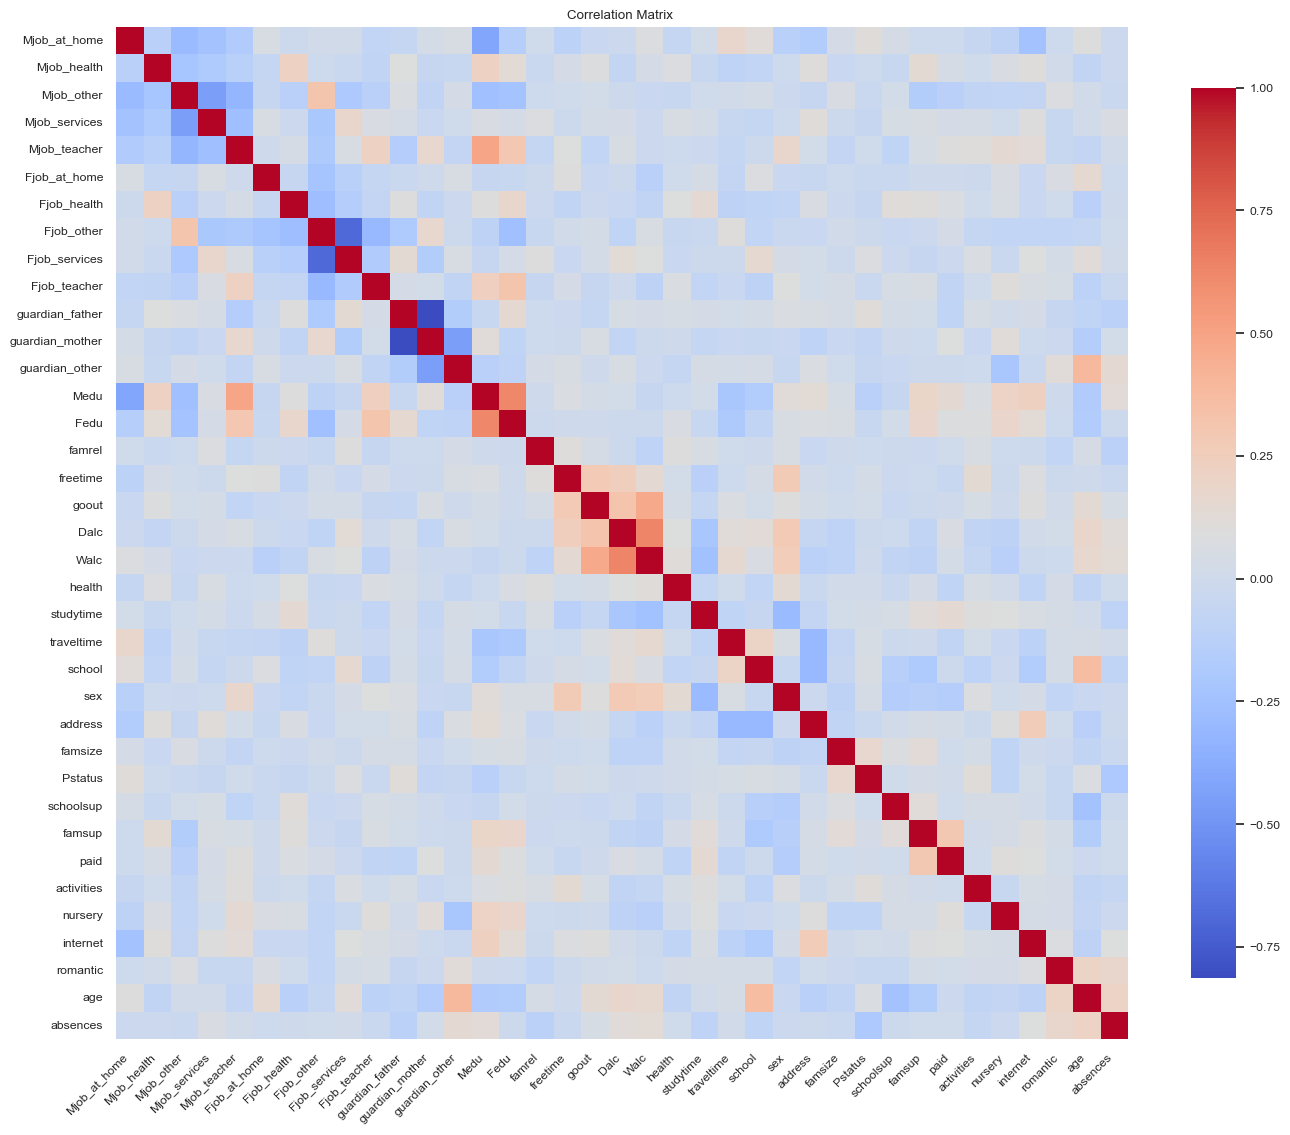

In [91]:
from utils import detect_outliers_iqr
from importlib import reload
import visualizations
reload(visualizations)

import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline

# Mapeo genérico para todas las binarias
def map_binaries(df):
    return df.replace({
        'school':   {'GP':0, 'MS':1},
        'sex':      {'F':0, 'M':1},
        'address':  {'U':1, 'R':0},
        'famsize':  {'LE3':0,'GT3':1},
        'Pstatus':  {'T':1, 'A':0},
        'schoolsup':{'yes':1,'no':0},
        'famsup':   {'yes':1,'no':0},
        'paid':     {'yes':1,'no':0},
        'activities':{'yes':1,'no':0},
        'nursery':  {'yes':1,'no':0},
        'internet': {'yes':1,'no':0},
        'romantic': {'yes':1,'no':0},
    })

preprocessor = ColumnTransformer([
    # 1. One-hot para ocupaciones y guardian (dense output)
    ('jobs', OneHotEncoder(sparse_output=False), ['Mjob','Fjob','guardian']),
    # 2. Ordinal para niveles y escalas 1–5
    ('ordinal', OrdinalEncoder(), 
        ['Medu','Fedu','famrel','freetime','goout','Dalc','Walc','health','studytime','traveltime']),
    # 3. Función de mapeo para todas las binarias
    ('binary', Pipeline([
        ('mapper', FunctionTransformer(map_binaries, validate=False))
    ]), ['school','sex','address','famsize','Pstatus',
         'schoolsup','famsup','paid','activities','nursery','internet','romantic']),
    # 4. Escalado para numéricas
    ('num', StandardScaler(), ['age','absences']),
], remainder='drop')

# Ajuste y transformación
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc  = preprocessor.transform(X_test)

# Reconstrucción de DataFrame con nombres de columna
ohe = preprocessor.named_transformers_['jobs']
ohe_feats = ohe.get_feature_names_out(['Mjob','Fjob','guardian']).tolist()
ord_feats = ['Medu','Fedu','famrel','freetime','goout','Dalc','Walc','health','studytime','traveltime']
bin_feats = ['school','sex','address','famsize','Pstatus',
             'schoolsup','famsup','paid','activities','nursery','internet','romantic']
num_feats = ['age','absences']

all_feature_names = ohe_feats + ord_feats + bin_feats + num_feats

X_train = pd.DataFrame(X_train_proc, columns=all_feature_names, index=X_train.index)
X_test  = pd.DataFrame(X_test_proc, columns=all_feature_names, index=X_test.index)

display(X_train.head(10)) 
display(X_test)
print("Dimensiones:", X_train.shape)
correlation_heatmap(X_train)




##  Correlation 


In the exploratory analysis of the preprocessed student dataset, we examined the Pearson correlation matrix among 37 features—after one-hot encoding of categorical variables—and filtered out trivial correlations arising solely from complementary dummy variables (e.g., between different levels of the same original category). We identified seven non-obvious associations with absolute correlation coefficients |ρ| ≥ 0.35 that may yield pedagogical or behavioral insights and thus merit discussion in the final report.

| Pair of Features                                              |      ρ | Interpretation                                                                                                                                                               |
| ------------------------------------------------------------- | -----: | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Dalc** (weekday alcohol) ↔ **Walc** (weekend alcohol)       |  0.637 | Students who consume more alcohol on weekdays also tend to drink heavily on weekends, indicating a generalized pattern of risk behavior rather than isolated episodes.       |
| **Medu** (mother’s education) ↔ **Fedu** (father’s education) |  0.621 | Strong educational homogamy in the parental couple suggests that children in households with two highly educated parents may benefit from compounded academic support.       |
| **Mjob\_teacher** ↔ **Medu**                                  |  0.491 | Mothers employed as teachers have, unsurprisingly, higher formal education; this quantifies why “mother-is-teacher” could serve as a proxy for parental educational capital. |
| **goout** (socializing) ↔ **Walc**                            |  0.469 | A more active social life correlates with increased weekend drinking, linking leisure patterns to potential impacts on study time and academic outcomes.                     |
| **Mjob\_at\_home** ↔ **Medu**                                 | –0.412 | Stay-at-home mothers tend to have lower formal education, complementing the previous finding and highlighting heterogeneous family environments.                             |
| **guardian\_other** ↔ **age**                                 |  0.386 | Older students more frequently report guardians other than mother or father (e.g., grandparents or themselves), suggesting shifts in living arrangements with age.           |
| **school** (GP vs MS) ↔ **age**                               |  0.363 | One of the two schools consistently enrolls slightly older students, possibly reflecting different admission cut-offs or retention policies.                                 |


In [92]:
import utils
reload(utils)
from utils import build_features


X_train = build_features(X_train)
X_test = build_features(X_test)




## Feature Importance 

c:\Users\alfre\Desktop\clase\Elements of Artificial Inteligence\Project-2\student-intervention-ml-pipeline\visualizations.py:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=top, palette="viridis")


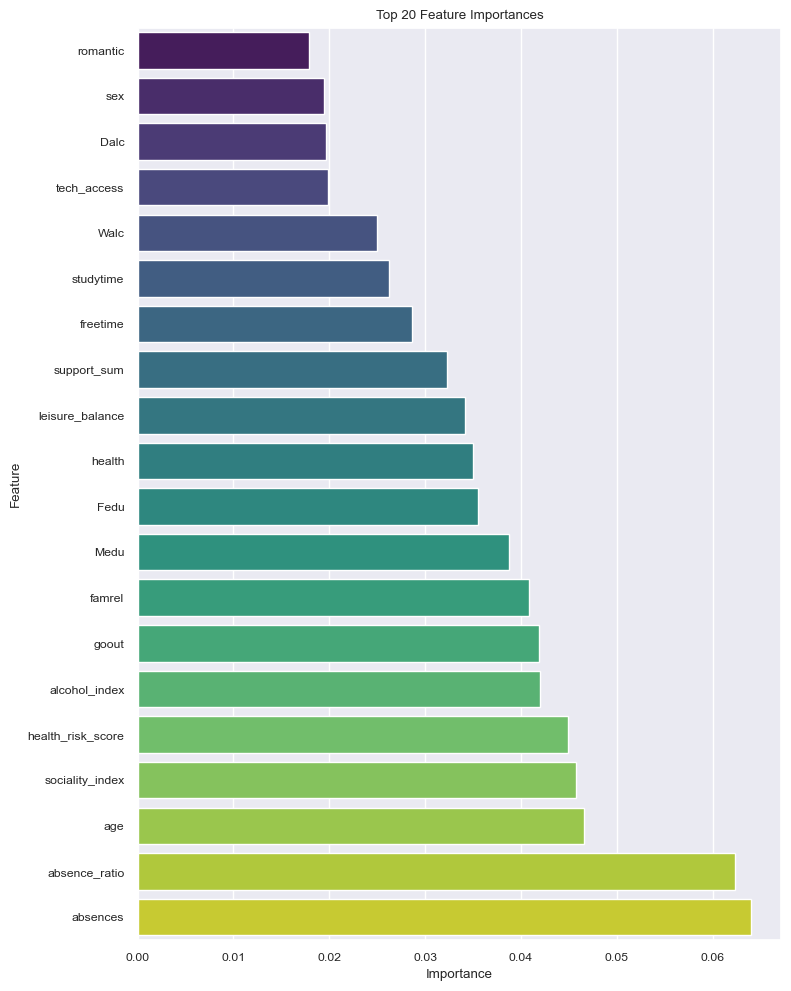

,rank,feature,importance
45,46,long_commuter_flag,0.001936
20,21,support_mismatch,0.016408
16,17,tech_access,0.019871
12,13,support_sum,0.032282
11,12,leisure_balance,0.034115
5,6,alcohol_index,0.042032
4,5,health_risk_score,0.044902
3,4,sociality_index,0.045731
1,2,absence_ratio,0.062361


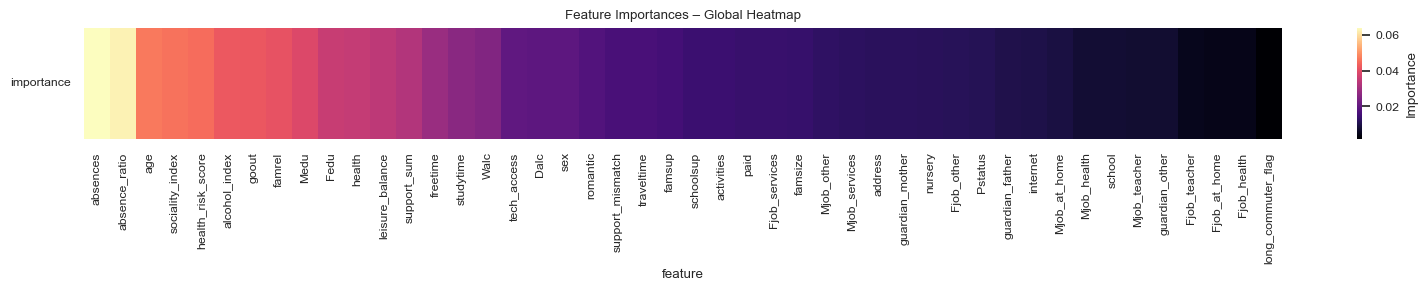

In [93]:
from visualizations import feature_importance_heatmap
importance_df,_ = compute_feature_importance(X_train, y_train)


plot_feature_importance(importance_df, top_n=20)

importance_sorted = importance_df.sort_values('importance', ascending=False).reset_index(drop=True)
importance_sorted['rank'] = importance_sorted.index + 1

# List of newly engineered features
new_features = [
    'leisure_balance',
    'sociality_index',
    'alcohol_index',
    'health_risk_score',
    'tech_access',
    'support_sum',
    'support_mismatch',
    'absence_ratio',
    'long_commuter_flag'
]

# Filter and display name, importance, and ranking for new features
result = (
    importance_sorted
    .loc[importance_sorted['feature'].isin(new_features), ['rank', 'feature', 'importance']]
    .sort_values('rank',ascending=False)
)
display(result)
feature_importance_heatmap(importance_df)


## Dimension Reduction 

Explicar brevemente que es el PCA, con formulas y tal

In [94]:

# print("Doing PCA on all preprocessed features …")

# from utils import preprocess_and_pca
# import numpy as np

# X_train,X_test,pca=preprocess_and_pca(X_train,X_test)
# plot_pca_variance(pca.explained_variance_ratio_)
# var_exp = pca.explained_variance_ratio_[:5].sum() * 100
# print(f"Las 3 primeras componentes explican el {var_exp:.2f}% de la varianza total.")
# # Mostrar la varianza explicada acumulada por componente



















# import matplotlib.pyplot as plt

# plt.figure(figsize=(8, 4))
# plt.plot(np.cumsum(pca.explained_variance_ratio_)*100, marker='o')
# plt.xlabel("Número de componentes principales")
# plt.ylabel("Varianza explicada acumulada (%)")
# plt.title("Varianza explicada acumulada por PCA")
# plt.grid(True)
# plt.show()

# # Mostrar los pesos (loadings) de las primeras componentes principales
# n_components_to_show = 3
# for i in range(n_components_to_show):
#     comp = pca.components_[i]
#     sorted_idx = np.argsort(np.abs(comp))[::-1]
#     print(f"\nTop features en la componente principal {i+1}:")
#     for idx in sorted_idx[:10]:
#         print(f"  {all_feature_names[idx]:<20} {comp[idx]: .3f}")

#     # Gráfico de barras de los pesos de las top features
#     plt.figure(figsize=(8, 4))
#     top_idx = sorted_idx[:10]
#     plt.barh([all_feature_names[j] for j in top_idx][::-1], comp[top_idx][::-1])
#     plt.title(f'Pesos de las top 10 features en PC{i+1}')
#     plt.xlabel('Peso')
#     plt.tight_layout()
#     plt.show()



A pesar de los resultados decidimos aumentar el numero de componentes que nos quedabamos con un número de 32



# Model creation before oversampling 

In [95]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, stratify=y_train, random_state=42
)
print(f"[report] Shapes: X_train={X_train.shape}, X_val={X_val.shape}, X_test={X_test.shape}")

[report] Shapes: X_train=(237, 46), X_val=(79, 46), X_test=(79, 46)


In [96]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

model_params = {
    "logreg": {
        "model": LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42),
        "params": {"C": [0.01, 0.1, 1, 10]},
    },
    "ridge": {
        "model": RidgeClassifier(class_weight="balanced", random_state=42),
        "params": {"alpha": [0.1, 1.0, 10.0]},
    },
    "rf": {
        "model": RandomForestClassifier(class_weight="balanced", random_state=42),
        "params": {"n_estimators": [200, 400], "max_depth": [None, 10, 20]},
    },
    "gb": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {"n_estimators": [100, 200], "learning_rate": [0.01, 0.1], "max_depth": [3, 5]},
    },
    "ada": {
        "model": AdaBoostClassifier(random_state=42),
        "params": {"n_estimators": [50, 100], "learning_rate": [0.01, 0.1, 1]},
    },
    "et": {
        "model": ExtraTreesClassifier(class_weight="balanced", random_state=42),
        "params": {"n_estimators": [100, 200], "max_depth": [None, 10, 20]},
    },
    "xgb": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
        "params": {"n_estimators": [100, 200], "max_depth": [3, 6]},
    },
    "svm": {
        "model": SVC(class_weight="balanced", probability=True, random_state=42),
        "params": {"C": [0.1, 1, 10], "kernel": ["rbf"]},
    },
    "knn": {
        "model": KNeighborsClassifier(),
        "params": {"n_neighbors": [3, 5, 7]},
    },
    "nb": {
        "model": GaussianNB(),
        "params": {},  # Normalmente no tiene hiperparámetros importantes para tunear
    },
    "dt": {
        "model": DecisionTreeClassifier(class_weight="balanced", random_state=42),
        "params": {"max_depth": [None, 10, 20], "min_samples_split": [2, 5, 10]},
    },
    "mlp": {
        "model": MLPClassifier(max_iter=500, random_state=42),
        "params": {"hidden_layer_sizes": [(50,), (100,), (100, 50)], "alpha": [0.0001, 0.001], "learning_rate": ["constant", "adaptive"]},
    },
    
    # "mlp": {
    #     "model": MLPClassifier(max_iter=500, random_state=42),
    #     "params": {
    #         "hidden_layer_sizes": [(50,), (100,), (100, 50), (150, 100, 50)],
    #         "activation": ["relu", "tanh", "logistic"],
    #         "solver": ["adam", "sgd"],
    #         "alpha": [0.0001, 0.001, 0.01],
    #         "learning_rate": ["constant", "invscaling", "adaptive"],
    #         "learning_rate_init": [0.001, 0.01],
    #         "batch_size": [32, 64],
    #     },
    # },
    "lda": {
        "model": LinearDiscriminantAnalysis(),
        "params": {"solver": ["svd", "lsqr"]},
    },
    "qda": {
        "model": QuadraticDiscriminantAnalysis(),
        "params": {},  # Generalmente no se tunea mucho
    },
}

In [97]:
import time
import pandas as pd
from sklearn.model_selection import GridSearchCV

scoring = ['roc_auc', 'f1', 'recall', 'balanced_accuracy']
results = []
best_models = {}

# Diccionario para nombres legibles
model_names = {
    'logreg': 'Logistic Regression',
    'ridge': 'Ridge Classifier',
    'rf': 'Random Forest',
    'gb': 'Gradient Boosting',
    'ada': 'AdaBoost',
    'et': 'Extra Trees',
    'xgb': 'XGBoost',
    'svm': 'SVM',
    'knn': 'K-Nearest Neighbors',
    'nb': 'Gaussian Naive Bayes',
    'dt': 'Decision Tree',
    'mlp': 'Multi-Layer Perceptron',
    'lda': 'Linear Discriminant Analysis',
    'qda': 'Quadratic Discriminant Analysis',
}

for name, mp in model_params.items():
    print(f"Tuning {name}...")
    gs = GridSearchCV(
        estimator=mp["model"],
        param_grid=mp["params"],
        scoring=scoring,
        refit="roc_auc",
        cv=5,
        n_jobs=-1,
    )
    start_time = time.time()
    gs.fit(X_train, y_train)
    elapsed_time = time.time() - start_time

    best_models[name] = gs.best_estimator_

    for metric in scoring:
        results.append({
            'model': name,
            'metric': metric,
            'mean': gs.cv_results_[f'mean_test_{metric}'][gs.best_index_],
            'std': gs.cv_results_[f'std_test_{metric}'][gs.best_index_],
            'time_sec': elapsed_time
        })

# Guardar toda la información
results_df = pd.DataFrame(results)




# Crear tabla limpia para imprimir
pivot_df = results_df.pivot(index='model', columns='metric', values=['mean', 'std'])

# Combinar mean ± std en una sola celda
clean_df = pd.DataFrame(index=pivot_df.index)

for metric in scoring:
    clean_df[metric] = pivot_df['mean', metric].round(4).astype(str) + " ± " + pivot_df['std', metric].round(4).astype(str)

# Agregar columna de tiempo (mismo tiempo para todas las métricas → tomamos el primero)
time_df = results_df[['model', 'time_sec']].drop_duplicates().set_index('model')
clean_df['time_sec'] = time_df['time_sec'].round(2)

# Cambiar los índices de abreviación a nombres completos
clean_df.index = clean_df.index.map(model_names)

# # Mostrar tabla limpia
display(clean_df)


Tuning logreg...
Tuning ridge...
Tuning rf...
Tuning gb...
Tuning ada...
Tuning et...
Tuning xgb...


c:\Users\alfre\Desktop\clase\Elements of Artificial Inteligence\Project-2\student-intervention-ml-pipeline\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:09:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Tuning svm...
Tuning knn...
Tuning nb...
Tuning dt...
Tuning mlp...
Tuning lda...
Tuning qda...


c:\Users\alfre\Desktop\clase\Elements of Artificial Inteligence\Project-2\student-intervention-ml-pipeline\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\alfre\Desktop\clase\Elements of Artificial Inteligence\Project-2\student-intervention-ml-pipeline\.venv\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\alfre\Desktop\clase\Elements of Artificial Inteligence\Project-2\student-intervention-ml-pipeline\.venv\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


,roc_auc,f1,recall,balanced_accuracy,time_sec
model,,,,,
AdaBoost,0.5285 ± 0.0895,0.2305 ± 0.1327,0.1933 ± 0.1068,0.5027 ± 0.0514,0.76
Decision Tree,0.4979 ± 0.0835,0.3548 ± 0.1024,0.3992 ± 0.1506,0.5018 ± 0.0759,0.13
Extra Trees,0.5586 ± 0.0849,0.1003 ± 0.1003,0.0658 ± 0.073,0.492 ± 0.0397,1.09
Gradient Boosting,0.5955 ± 0.0615,0.3523 ± 0.1081,0.3192 ± 0.1122,0.5464 ± 0.0569,1.75
K-Nearest Neighbors,0.6091 ± 0.0571,0.3849 ± 0.0829,0.3233 ± 0.1098,0.5831 ± 0.0438,0.07
Linear Discriminant Analysis,0.5108 ± 0.0826,0.3166 ± 0.1233,0.28 ± 0.1091,0.5209 ± 0.0776,0.05
Logistic Regression,0.5515 ± 0.0421,0.4329 ± 0.0788,0.5233 ± 0.1429,0.5511 ± 0.0553,0.10
Multi-Layer Perceptron,0.5562 ± 0.0651,0.3404 ± 0.1322,0.3075 ± 0.1224,0.5341 ± 0.0852,3.79
Gaussian Naive Bayes,0.4798 ± 0.0599,0.2728 ± 0.099,0.2817 ± 0.1185,0.4587 ± 0.0619,0.03


## Metrics 

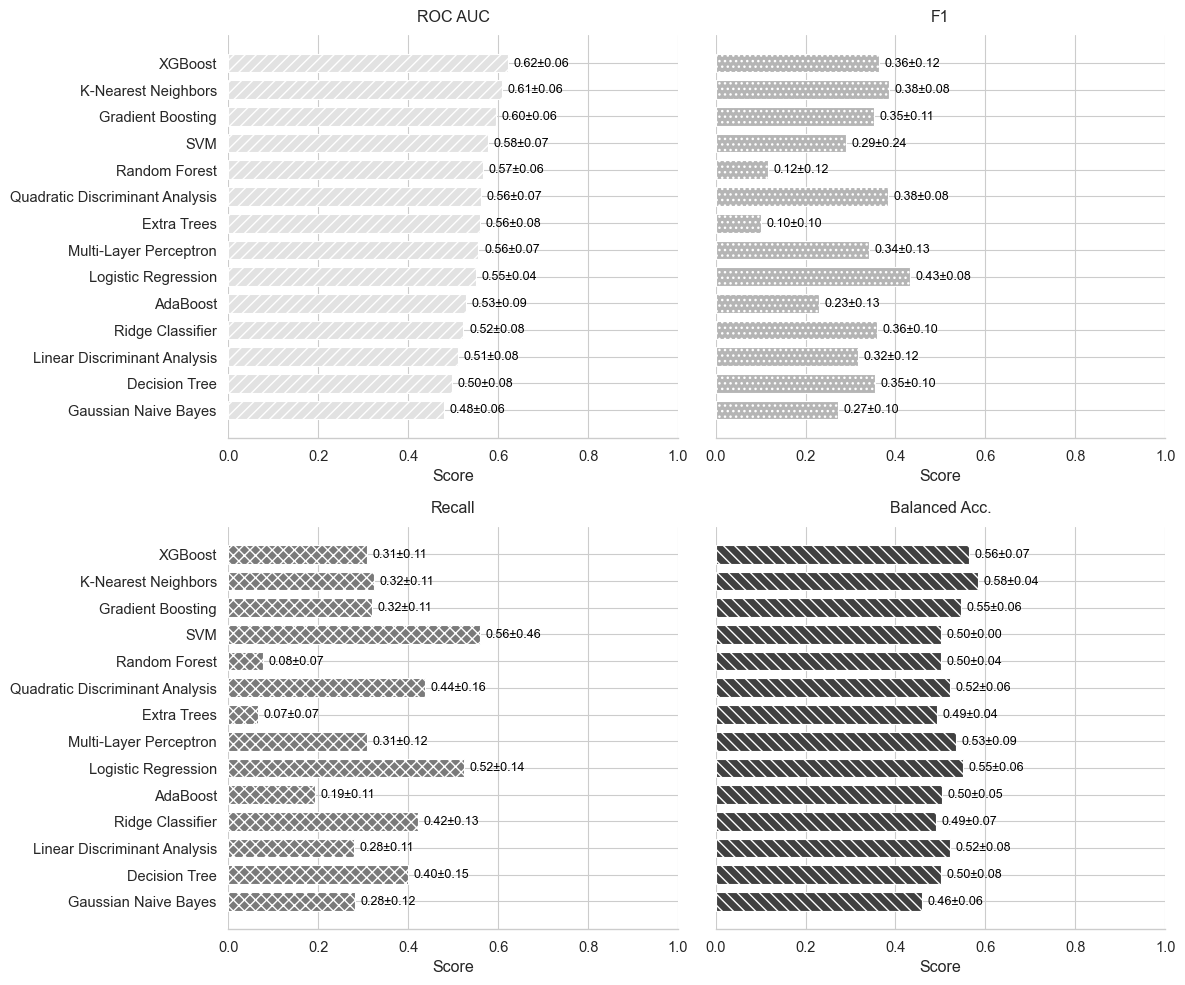

In [98]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Prepara tu DataFrame: names completos + mean/std ya calculados
df = results_df.copy()
df['model_full'] = df['model'].map(model_names)

# Parámetros
metrics = ['roc_auc','f1','recall','balanced_accuracy']
titles  = ['ROC AUC','F1','Recall','Balanced Acc.']

sns.set_context("paper", font_scale=1.2)
plt.rc("font", family="serif")
sns.set_style("whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
axes = axes.flatten()

# Paleta gris + hatches
palette = sns.color_palette("Greys", n_colors=len(metrics))
hatches = ['///','...','xxx','\\\\\\']

for ax, metric, title, pal, hatch in zip(axes, metrics, titles, palette, hatches):
    sub = df[df.metric == metric].copy()
    sub = sub.sort_values("mean", ascending=True)  # ascendente para barh
    sub['model_full'] = sub['model_full'].astype(str)

    # barra horizontal sin whiskers
    bars = ax.barh(
        y=sub['model_full'],
        width=sub['mean'],
        color=pal,
        hatch=hatch,
        height=0.7
    )
    # etiquetas “mean±std”
    labels = [
        f"{m:.2f}±{s:.2f}"
        for m, s in zip(sub['mean'], sub['std'])
    ]
    ax.bar_label(bars, labels=labels, padding=4, fontsize=9, color="black")

    ax.set_title(title, pad=10)
    ax.set_xlim(0, 1)
    ax.set_xlabel("Score")
    ax.set_ylabel("")  # ya está en y-ticks
    sns.despine(ax=ax, left=True)

plt.tight_layout()
plt.savefig("fig_model_comparison.pdf")  # vectorial para paper
plt.show()


## Model deployment 

🔄 Retraining and tuning Logistic Regression…
🔄 Retraining and tuning K-Nearest Neighbors…
🔄 Retraining and tuning Quadratic Discriminant Analysis…
🔄 Retraining and tuning XGBoost…


c:\Users\alfre\Desktop\clase\Elements of Artificial Inteligence\Project-2\student-intervention-ml-pipeline\.venv\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\alfre\Desktop\clase\Elements of Artificial Inteligence\Project-2\student-intervention-ml-pipeline\.venv\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\alfre\Desktop\clase\Elements of Artificial Inteligence\Project-2\student-intervention-ml-pipeline\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:09:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iter

🔄 Retraining and tuning Ridge Classifier…


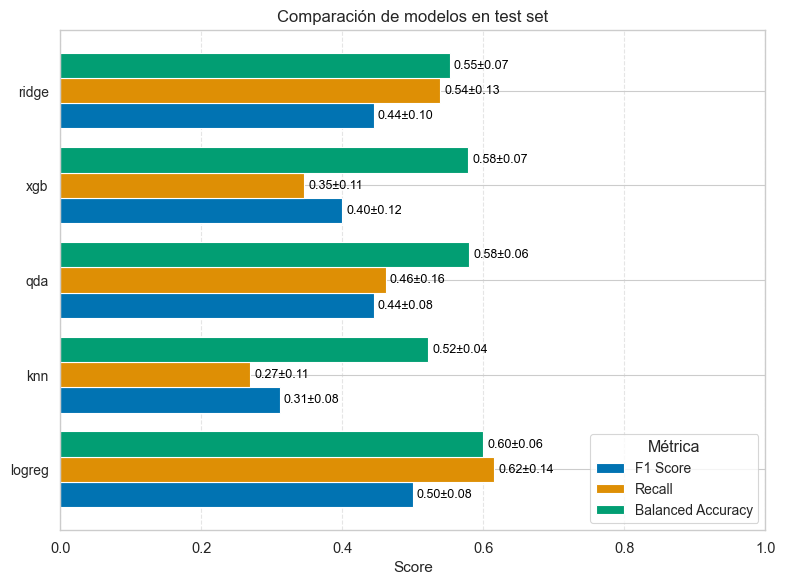

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_auc_score, f1_score, recall_score, balanced_accuracy_score
)
from sklearn.model_selection import GridSearchCV

# 1) Retrain en train+val y evalúa en test
top_names = (
    results_df[results_df.metric == "f1"]
    .sort_values("mean", ascending=False)
    .head(5)['model']
    .tolist()
)
final_results = []
for name in top_names:
    print(f"🔄 Retraining and tuning {model_names[name]}…")
    gs = GridSearchCV(
        estimator = model_params[name]['model'],
        param_grid = model_params[name]['params'],
        scoring    = scoring,
        refit      = 'f1',
        cv         = 5,
        n_jobs     = -1
    )
    gs.fit(X_train, y_train)
    best = gs.best_estimator_

    y_pred  = best.predict(X_test)


    rec = {
        'Model': name,
        'F1 Score':        f1_score(y_test,          y_pred),
        'Recall':          recall_score(y_test,      y_pred),
        'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred),
    }
    final_results.append(rec)   # ← ¡No olvides esto!



final_df = pd.DataFrame(final_results)
# Renombramos y reordenamos columnas
final_df = final_df[['Model', 'F1 Score', 'Recall', 'Balanced Accuracy']]


results_df_actual=final_df.copy()
# 2) Extraemos las desviaciones estándar de CV desde results_df
std_records = []
for name in top_names:
    std_records.append({
        'Model': model_names[name],
        'F1 Score':        results_df[(results_df.metric=='f1')               & (results_df.model==name)]['std'].iloc[0],
        'Recall':          results_df[(results_df.metric=='recall')          & (results_df.model==name)]['std'].iloc[0],
        'Balanced Accuracy': results_df[(results_df.metric=='balanced_accuracy') & (results_df.model==name)]['std'].iloc[0],
    })
std_df = pd.DataFrame(std_records)




# 3) Plot agrupado horizontal con barras de error
metrics   = ['F1 Score', 'Recall', 'Balanced Accuracy']
n_metrics = len(metrics)
y_pos     = np.arange(len(final_df))
bar_h     = 0.8 / n_metrics

palette = sns.color_palette("colorblind", n_colors=n_met)

fig, ax = plt.subplots(figsize=(8, 6))

for i, metric in enumerate(metrics):
    # 1) Dibujamos la barra SIN bandas de error
    bars = ax.barh(
        y       = y_pos + i*bar_h,
        width   = final_df[metric],
        height  = bar_h,
        label   = metric,
        color   = palette[i]
    )
    # 2) Anotamos cada barra con "mean±std"
    labels = [
        f"{mean:.2f}±{std:.2f}"
        for mean, std in zip(final_df[metric], std_df[metric])
    ]
    # Usamos bar_label para que posicione bien el texto
    ax.bar_label(bars,
                 labels=labels,
                 padding=3,        # separación de la barra
                 fmt="%s",         # ya formateado
                 fontsize=9,
                 color="black")    # color que contraste con las barras

# Etiquetas y estilo
ax.set_yticks(y_pos + bar_h*(n_metrics-1)/2)
ax.set_yticklabels(final_df['Model'], fontsize=10)
ax.set_xlim(0, 1)
ax.set_xlabel("Score", fontsize=11)
ax.grid(axis='x', linestyle='--', alpha=0.5)
ax.legend(title="Métrica", loc='lower right', fontsize=10)
plt.title("Comparación de modelos en test set", fontsize=12)

plt.tight_layout()
plt.savefig("comparacion_modelos.pdf")   # Vectorial para tu paper
plt.show()


# Oversampling with SMOTE

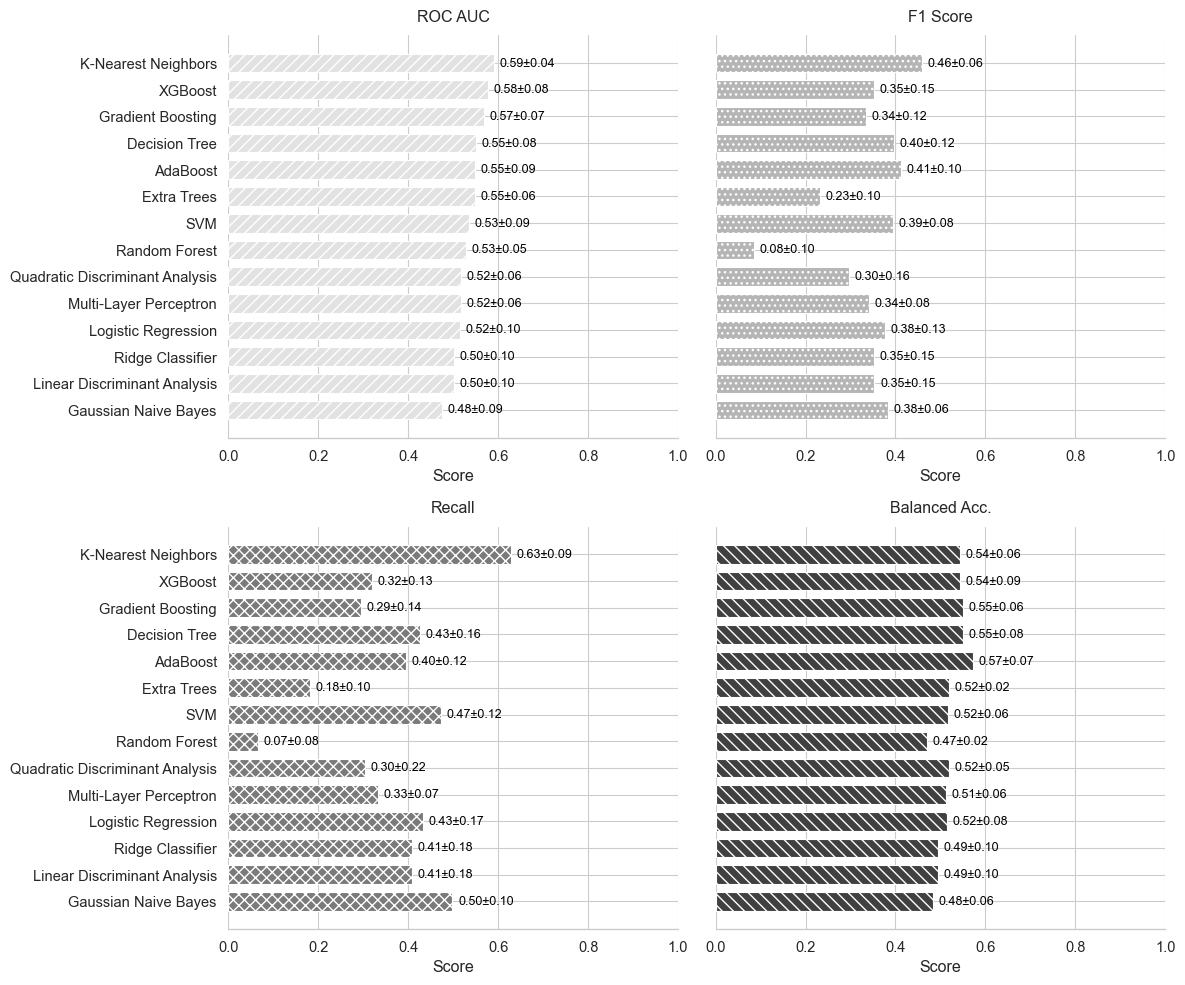

In [100]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import GridSearchCV, cross_validate
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Define scoring metrics
scoring = {
    'ROC_AUC': 'roc_auc',
    'F1': 'f1',
    'RECALL': 'recall',
    'BALANCED_ACCURACY': 'balanced_accuracy'
}

# Build the pipeline template
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),  # SMOTE solo en train
    ('clf', LogisticRegression()),      # placeholder
])

# Prepare a DataFrame to store cross-validation results
results = []

for name, mp in model_params.items():
    # Clone and set the classifier in the pipeline
    pipe = ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('clf', mp["model"])
    ])
    
    # Run cross-validation for all scoring metrics
    cv_res = cross_validate(pipe, X_train, y_train, cv=5, scoring=scoring, return_train_score=False, n_jobs=-1)
    
    # Aggregate mean and std for each metric
    row = {'Model': name}
    for metric in scoring:
        row[f'mean_{metric}'] = np.mean(cv_res[f'test_{metric}'])
        row[f'std_{metric}'] = np.std(cv_res[f'test_{metric}'])
    results.append(row)


df_results = pd.DataFrame(results)
# Mapeo a nombres legibles
df_results['Model'] = df_results['Model'].map(model_names)

# --------------------------------------------------
# 2) Preparar paleta y hatches
# --------------------------------------------------
metrics = ['ROC_AUC','F1','RECALL','BALANCED_ACCURACY']
titles  = ['ROC AUC','F1 Score','Recall','Balanced Acc.']

sns.set_context("paper", font_scale=1.2)
plt.rc("font", family="serif")
sns.set_style("whitegrid")

palette = sns.color_palette("Greys", n_colors=len(metrics))
hatches = ['///','...','xxx','\\\\\\']

# --------------------------------------------------
# 3) Dibujar 2×2 subplots de barras horizontales
# --------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(12,10), sharey=True)
axes = axes.flatten()

for ax, met, title, col, hatch in zip(axes, metrics, titles, palette, hatches):
    # ordenar de menor a mayor para barh
    sub = df_results.sort_values(f'mean_{met}', ascending=True)

    bars = ax.barh(
        y      = sub['Model'],
        width  = sub[f'mean_{met}'],
        height = 0.7,
        color  = col,
        hatch  = hatch
    )
    # etiquetas mean±std
    labels = [
        f"{m:.2f}±{s:.2f}"
        for m, s in zip(sub[f'mean_{met}'], sub[f'std_{met}'])
    ]
    ax.bar_label(bars, labels=labels, padding=4, fontsize=9, color="black")

    ax.set_title(title, pad=10)
    ax.set_xlim(0,1)
    ax.set_xlabel("Score")
    ax.set_ylabel("")   # el nombre ya está en el y-tick
    sns.despine(ax=ax, left=True)

plt.tight_layout()
plt.savefig("cv_comparison_smote.pdf")  # vectorial para tu paper
plt.show()




🔄 Ajustando con SMOTE y GridSearch: logreg
🔄 Ajustando con SMOTE y GridSearch: knn
🔄 Ajustando con SMOTE y GridSearch: qda
🔄 Ajustando con SMOTE y GridSearch: xgb


c:\Users\alfre\Desktop\clase\Elements of Artificial Inteligence\Project-2\student-intervention-ml-pipeline\.venv\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\alfre\Desktop\clase\Elements of Artificial Inteligence\Project-2\student-intervention-ml-pipeline\.venv\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\alfre\Desktop\clase\Elements of Artificial Inteligence\Project-2\student-intervention-ml-pipeline\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:09:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iter

🔄 Ajustando con SMOTE y GridSearch: ridge


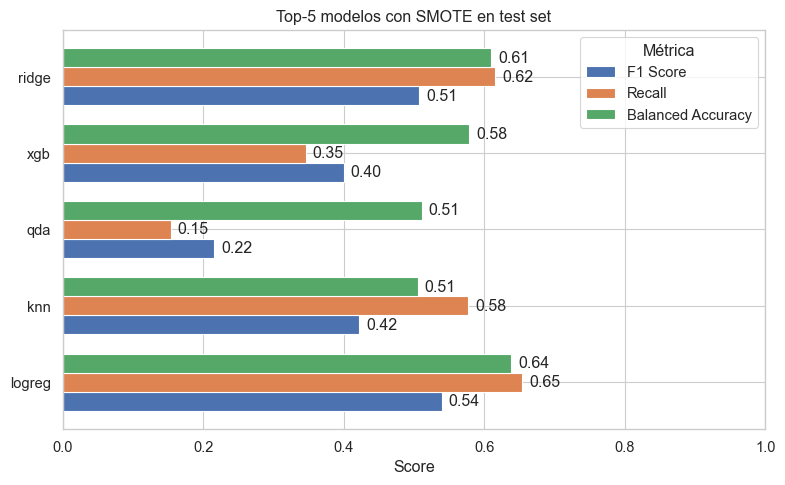

In [ ]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# --- 1) Retrain + GridSearch con SMOTE para los top-5 ---

# Asumimos que 'results_df' es tu DataFrame de cross-validate (con columnas 'model','metric','mean',...)
top5 = (
    results_df[results_df.metric=='f1']
    .sort_values('mean', ascending=False)
    .head(5)['model']
    .tolist()
)

smote_results = []
for name in top5:
    print(f"🔄 Ajustando con SMOTE y GridSearch: {name}")
    # Pipeline SMOTE + clasificador
    pipe = ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('clf', model_params[name]['model'])
    ])
    # Param grid solo para el clasificador
    param_grid = {
        f'clf__{p}': vals
        for p, vals in model_params[name]['params'].items()
    }
    gs = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring={'f1':'f1'},
        refit='f1',
        cv=5,
        n_jobs=-1,
        verbose=0
    )
    gs.fit(X_train, y_train)
    best = gs.best_estimator_
    y_pred = best.predict(X_test)

    smote_results.append({
        'Model': name,
        'F1 Score':        f1_score(y_test,          y_pred),
        'Recall':          recall_score(y_test,      y_pred),
        'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred),
    })

smote_df = pd.DataFrame(smote_results)
smote_df = smote_df.set_index('Model')

# --- 2) Gráfica top-5 SMOTE en test set ---

metrics = ['F1 Score','Recall','Balanced Accuracy']
n = len(smote_df)
y_pos = np.arange(n)

fig, ax = plt.subplots(figsize=(8,5))
bar_width = 0.25

for i, metric in enumerate(metrics):
    ax.barh(
        y_pos + (i-1)*bar_width,
        smote_df[metric],
        height=bar_width,
        label=metric
    )
    # anotaciones
    for j, val in enumerate(smote_df[metric]):
        ax.text(
            val + 0.01,
            j + (i-1)*bar_width,
            f"{val:.2f}",
            va='center'
        )

ax.set_yticks(y_pos)
ax.set_yticklabels(smote_df.index)
ax.set_xlabel('Score')
ax.set_xlim(0,1)
ax.set_title('Top-5 modelos con SMOTE en test set')
ax.legend(title='Métrica')
plt.tight_layout()
plt.show()



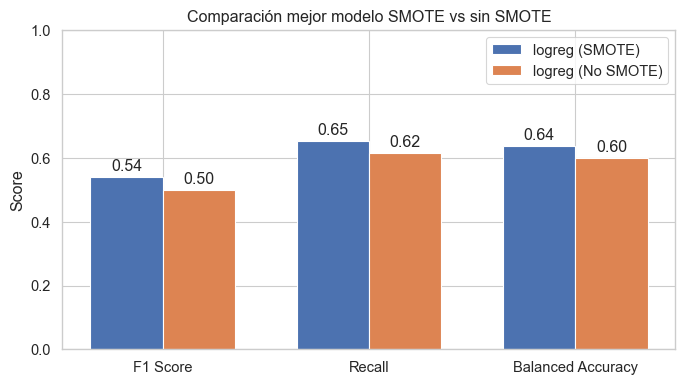

In [102]:
# --- 3) Comparación: mejor SMOTE vs mejor sin SMOTE ---

# mejor SMOTE (según F1)
best_smote = smote_df['F1 Score'].idxmax()
scores_smote = smote_df.loc[best_smote, metrics].values

# mejor sin SMOTE en results_df_actual (ya tienes su DataFrame)
best_nosmote = results_df_actual.set_index('Model')['F1 Score'].idxmax()
nosmote_df = results_df_actual.set_index('Model')
scores_nosmote = nosmote_df.loc[best_nosmote, metrics].values

# Dibujo comparativo
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(7,4))
ax.bar(x - width/2, scores_smote,  width, label=f'{best_smote} (SMOTE)')
ax.bar(x + width/2, scores_nosmote, width, label=f'{best_nosmote} (No SMOTE)')

# Anotaciones
for i, v in enumerate(scores_smote):
    ax.text(i - width/2, v+0.02, f"{v:.2f}", ha='center')
for i, v in enumerate(scores_nosmote):
    ax.text(i + width/2, v+0.02, f"{v:.2f}", ha='center')

ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0,1)
ax.set_ylabel('Score')
ax.set_title('Comparación mejor modelo SMOTE vs sin SMOTE')
ax.legend()
plt.tight_layout()
plt.show()

# Conclusion

# References